
# Number Partition Problem


## Introduction

In the Number Partitioning Problem [[1](#PartitionWiki)] we need to find how to partition a set of integers into two subsets of equal sums. In case such a partition does not exist, we can ask for a partition where the difference between the sums is minimal.

## Mathematical formulation

Given a set of numbers $S=\{s_1,s_2,...,s_n\}$, a partition is defined as $P_1,P_2 \subset \{1,...,n\}$, with $P_1\cup P_2=\{1,...,n\}$ and $P_1\cap P_2=\emptyset$. In the Number Partitioning Problem we need to determine a partition such that $|\sum_{j\in P_1}s_j-\sum_{j\in P_2}s_j|$ is minimal. A partition can be represented by a binary vector $x$ of size $n$, where we assign 0 or 1 for being in $P_1$ or $P_2$, respectively. The quantity we ask to minimize is $|\vec{x}\cdot \vec{s}-(1-\vec{x})\cdot\vec{s}|=|(2\vec{x}-1)\cdot\vec{s}|$. In practice we will minimize the square of this expression.

# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
from typing import cast

import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
# we define a matrix which gets a set of integers s and returns a pyomo model for the partitioning problem


def partite(s) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    SetSize = len(s)  # the set size
    model.x = pyo.Var(
        range(SetSize), domain=pyo.Binary
    )  # our variable is a binary vector

    # we define a cost function
    model.cost = pyo.Objective(
        expr=sum(((2 * model.x[i] - 1) * s[i]) for i in range(SetSize)) ** 2,
        sense=pyo.minimize,
    )

    return model

In [3]:
Myset = np.random.randint(1, 12, 10)
mylist = [int(x) for x in Myset]
print("This is my list: ", mylist)
set_partition_model = partite(mylist)

This is my list:  [10, 3, 6, 8, 4, 1, 9, 7, 10, 5]


In [4]:
set_partition_model.pprint()

1 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

1 Var Declarations
    x : Size=10, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [5]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [6]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [7]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=set_partition_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [8]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [9]:
with open("set_partition.qmod", "w") as f:
    f.write(qmod)

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/21161cd6-7312-4d2d-bc71-f1bebf04a4ca?version=0.38.0.dev42%2Bfd36e2c41c


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [11]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

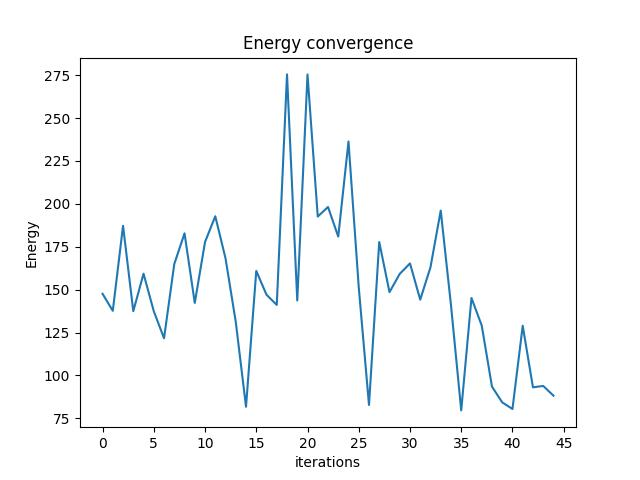

In [12]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [13]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    set_partition_model,
    vqe_result=vqe_result,
    penalty_energy=qaoa_config.penalty_energy,
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
213,0.001,1.0,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1]",1
314,0.001,1.0,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]",1
162,0.002,1.0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1]",2
229,0.001,1.0,"[1, 0, 0, 0, 1, 0, 0, 1, 1, 0]",1
219,0.001,1.0,"[0, 1, 1, 1, 1, 1, 1, 0, 0, 0]",1


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

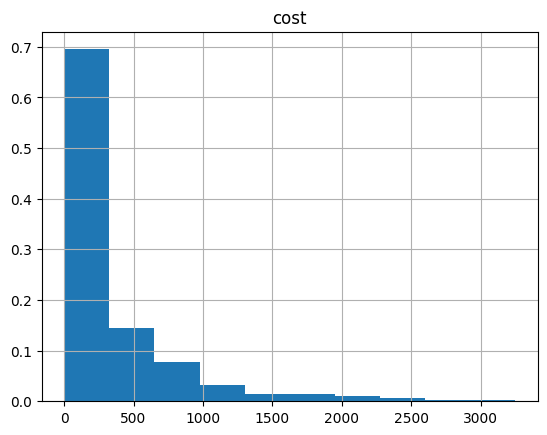

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the solution:

In [15]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

In [16]:
p1 = [mylist[i] for i in range(len(mylist)) if best_solution[i] == 0]
p2 = [mylist[i] for i in range(len(mylist)) if best_solution[i] == 1]
print("P1=", p1, ", total sum: ", sum(p1))
print("P2=", p2, ", total sum: ", sum(p2))
print("difference= ", abs(sum(p1) - sum(p2)))

P1= [3, 8, 4, 9, 7] , total sum:  31
P2= [10, 6, 1, 10, 5] , total sum:  32
difference=  1


Lastly, we can compare to the classical solution of the problem:

In [17]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(set_partition_model)

set_partition_model.display()

Model unknown

  Variables:
    x : Size=10, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   1.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   1.0 :     1 : False : False : Binary
          5 :     0 :   1.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   1.0 :     1 : False : False : Binary
          8 :     0 :   1.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   1.0

  Constraints:
    None


In [18]:
classical_solution = [pyo.value(set_partition_model.x[i]) for i in range(len(mylist))]

In [19]:
p1 = [mylist[i] for i in range(len(mylist)) if classical_solution[i] == 0]
p2 = [mylist[i] for i in range(len(mylist)) if classical_solution[i] == 1]
print("P1=", p1, ", total sum: ", sum(p1))
print("P2=", p2, ", total sum: ", sum(p2))
print("difference= ", abs(sum(p1) - sum(p2)))

P1= [10, 8, 9, 5] , total sum:  32
P2= [3, 6, 4, 1, 7, 10] , total sum:  31
difference=  1



## References

<a id='PartitionWiki'>[1]</a>: [Number Partitioning Problem (Wikipedia)](https://en.wikipedia.org/wiki/Partition_problem)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
